In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
months = ['October', 'November', 'December', 'January', 'February', 'March', 'April']

In [3]:
acc = list()

In [4]:
f1 = list()

In [5]:
err = list()

In [6]:
house_data = pd.read_csv("../preprocessed_data/oneHot_data.csv")

In [7]:
house_data.head()

,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Month,DayOfWeek,Day,HourofDay,...,T_stp_heat,Humidity,auxHeat1,fan,Thermostat_Temperature,Thermostat_Motion,Remote_Sensor_1_Temperature,Remote_Sensor_1_Motion,T_out,RH_out
0,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,0,11,0.330465,0.0,67.0,0.0,0.009112,1.808865
1,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,2,9,0.330465,0.0,67.0,0.0,0.009112,1.808865
2,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,20,20,0.330465,0.0,67.0,0.0,0.009112,1.808865
3,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,9,12,0.330465,0.0,67.0,0.0,0.009112,1.808865
4,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,0,8,0.330465,0.0,67.0,0.0,0.009112,1.808865


In [8]:
house_data.Month.value_counts()

4     7267
3     7132
12    7125
5     7123
11    6837
1     6797
10    6343
6     5986
2     4131
9       96
Name: Month, dtype: int64

In [9]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# October

In [10]:
working_df = house_data[house_data.Month == 10]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5069, 34) (5069, 21) (1268, 34) (1268, 21)


In [11]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 5069 samples, validate on 1268 samples
Epoch 1/20
5069/5069 [==============================] - 3s 496us/sample - loss: 0.6667 - accuracy: 0.9120 - val_loss: 0.4037 - val_accuracy: 0.9188
Epoch 2/20
5069/5069 [==============================] - 2s 415us/sample - loss: 0.3466 - accuracy: 0.9339 - val_loss: 0.3753 - val_accuracy: 0.9259
Epoch 3/20
5069/5069 [==============================] - 2s 365us/sample - loss: 0.3300 - accuracy: 0.9379 - val_loss: 0.3676 - val_accuracy: 0.9322
Epoch 4/20
5069/5069 [==============================] - 2s 367us/sample - loss: 0.3207 - accuracy: 0.9410 - val_loss: 0.3581 - val_accuracy: 0.9322
Epoch 5/20
5069/5069 [==============================] - 2s 370us/sample - loss: 0.3143 - accuracy: 0.9404 - val_loss: 0.3492 - val_accuracy: 0.9361
Epoch 6/20
5069/5069 [==============================] - 2s 368us/sample - loss: 0.3099 - accuracy: 0.9392 - val_loss: 0.3554 - val_accuracy: 0.9377
Epoch 7/20
5069/5069 [==============================] - 2s 367us

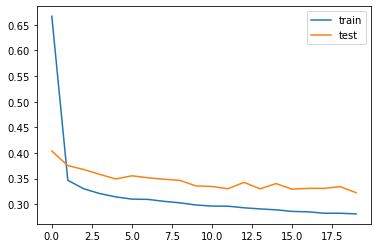

In [12]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

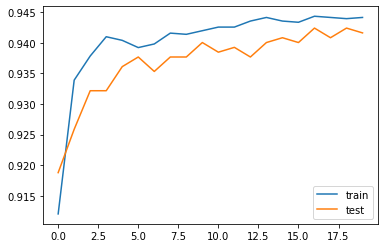

In [13]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [14]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

25830
24300
Error Percentage in predicted values is : 5.923344947735192 %


In [15]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9194699451560346

In [16]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [17]:
acc.append(max(history.history['accuracy']))

# November

In [18]:
working_df = house_data[house_data.Month == 11]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5464, 34) (5464, 21) (1367, 34) (1367, 21)


In [19]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 5464 samples, validate on 1367 samples
Epoch 1/20
5464/5464 [==============================] - 3s 474us/sample - loss: 1.4231 - accuracy: 0.7255 - val_loss: 1.1373 - val_accuracy: 0.7571
Epoch 2/20
5464/5464 [==============================] - 2s 399us/sample - loss: 1.0314 - accuracy: 0.7875 - val_loss: 1.0635 - val_accuracy: 0.7732
Epoch 3/20
5464/5464 [==============================] - 2s 421us/sample - loss: 0.9854 - accuracy: 0.7904 - val_loss: 1.0286 - val_accuracy: 0.7783
Epoch 4/20
5464/5464 [==============================] - 2s 441us/sample - loss: 0.9592 - accuracy: 0.7958 - val_loss: 1.0140 - val_accuracy: 0.7827
Epoch 5/20
5464/5464 [==============================] - 2s 366us/sample - loss: 0.9472 - accuracy: 0.7965 - val_loss: 0.9945 - val_accuracy: 0.7805
Epoch 6/20
5464/5464 [==============================] - 2s 348us/sample - loss: 0.9302 - accuracy: 0.7998 - val_loss: 0.9806 - val_accuracy: 0.7835
Epoch 7/20
5464/5464 [==============================] - 2s 436us

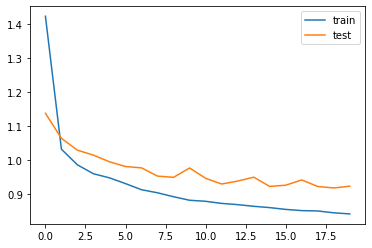

In [20]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

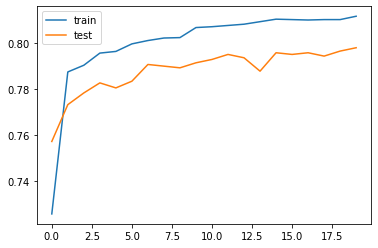

In [21]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [22]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

103245
90000
Error Percentage in predicted values is : 12.828708412029638 %


In [23]:
f1_score(y_test, y_predicted, average = 'weighted')

0.7169570852668591

In [24]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [25]:
acc.append(max(history.history['accuracy']))

# December

In [26]:
working_df = house_data[house_data.Month == 12]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5695, 34) (5695, 21) (1424, 34) (1424, 21)


In [27]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 5695 samples, validate on 1424 samples
Epoch 1/20
5695/5695 [==============================] - 2s 405us/sample - loss: 1.3751 - accuracy: 0.7308 - val_loss: 1.0390 - val_accuracy: 0.7893
Epoch 2/20
5695/5695 [==============================] - 2s 348us/sample - loss: 0.9973 - accuracy: 0.7944 - val_loss: 0.9782 - val_accuracy: 0.8055
Epoch 3/20
5695/5695 [==============================] - 2s 344us/sample - loss: 0.9653 - accuracy: 0.8019 - val_loss: 0.9423 - val_accuracy: 0.8020
Epoch 4/20
5695/5695 [==============================] - 2s 366us/sample - loss: 0.9411 - accuracy: 0.8037 - val_loss: 0.9327 - val_accuracy: 0.8125
Epoch 5/20
5695/5695 [==============================] - 2s 347us/sample - loss: 0.9287 - accuracy: 0.8058 - val_loss: 0.9116 - val_accuracy: 0.8139
Epoch 6/20
5695/5695 [==============================] - 2s 347us/sample - loss: 0.9155 - accuracy: 0.8063 - val_loss: 0.9007 - val_accuracy: 0.8139
Epoch 7/20
5695/5695 [==============================] - 2s 349us

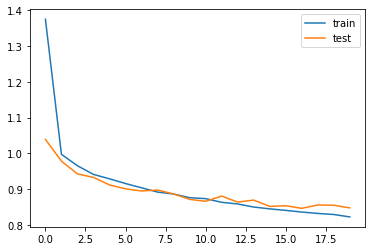

In [28]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

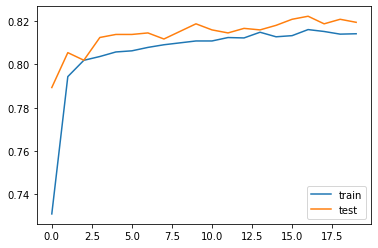

In [29]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [30]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

117720
102300
Error Percentage in predicted values is : 13.09887869520897 %


In [31]:
f1_score(y_test, y_predicted, average = 'weighted')

0.7440640769416382

In [32]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [33]:
acc.append(max(history.history['accuracy']))

# January

In [34]:
working_df = house_data[house_data.Month == 1]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5432, 34) (5432, 21) (1359, 34) (1359, 21)


In [35]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 5432 samples, validate on 1359 samples
Epoch 1/20
5432/5432 [==============================] - 2s 432us/sample - loss: 1.3439 - accuracy: 0.7178 - val_loss: 1.0751 - val_accuracy: 0.7697
Epoch 2/20
5432/5432 [==============================] - 2s 369us/sample - loss: 1.0526 - accuracy: 0.7859 - val_loss: 1.0161 - val_accuracy: 0.7991
Epoch 3/20
5432/5432 [==============================] - 2s 399us/sample - loss: 1.0169 - accuracy: 0.7929 - val_loss: 1.0019 - val_accuracy: 0.7896
Epoch 4/20
5432/5432 [==============================] - 2s 412us/sample - loss: 1.0028 - accuracy: 0.7934 - val_loss: 0.9868 - val_accuracy: 0.7984
Epoch 5/20
5432/5432 [==============================] - 2s 374us/sample - loss: 0.9812 - accuracy: 0.7953 - val_loss: 0.9923 - val_accuracy: 0.7940
Epoch 6/20
5432/5432 [==============================] - 2s 374us/sample - loss: 0.9733 - accuracy: 0.7964 - val_loss: 0.9623 - val_accuracy: 0.8035
Epoch 7/20
5432/5432 [==============================] - 2s 378us

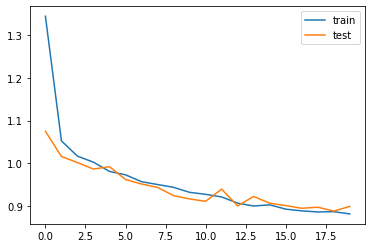

In [36]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

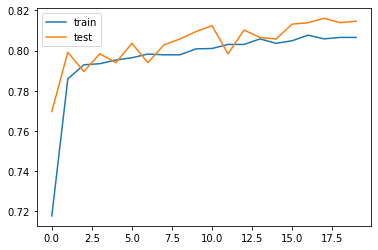

In [37]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [38]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

187995
182700
Error Percentage in predicted values is : 2.8165642703263387 %


In [39]:
f1_score(y_test, y_predicted, average = 'weighted')

0.7393260944715906

In [40]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [41]:
acc.append(max(history.history['accuracy']))

# February

In [42]:
working_df = house_data[house_data.Month == 2]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3300, 34) (3300, 21) (825, 34) (825, 21)


In [43]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 3300 samples, validate on 825 samples
Epoch 1/20
3300/3300 [==============================] - 1s 431us/sample - loss: 1.6119 - accuracy: 0.6755 - val_loss: 1.2349 - val_accuracy: 0.7248
Epoch 2/20
3300/3300 [==============================] - 1s 319us/sample - loss: 1.1651 - accuracy: 0.7533 - val_loss: 1.1711 - val_accuracy: 0.7394
Epoch 3/20
3300/3300 [==============================] - 1s 323us/sample - loss: 1.1106 - accuracy: 0.7603 - val_loss: 1.1516 - val_accuracy: 0.7479
Epoch 4/20
3300/3300 [==============================] - 1s 349us/sample - loss: 1.0858 - accuracy: 0.7688 - val_loss: 1.1134 - val_accuracy: 0.7515
Epoch 5/20
3300/3300 [==============================] - 1s 328us/sample - loss: 1.0723 - accuracy: 0.7733 - val_loss: 1.0984 - val_accuracy: 0.7697
Epoch 6/20
3300/3300 [==============================] - 1s 323us/sample - loss: 1.0528 - accuracy: 0.7791 - val_loss: 1.0822 - val_accuracy: 0.7673
Epoch 7/20
3300/3300 [==============================] - 1s 326us/

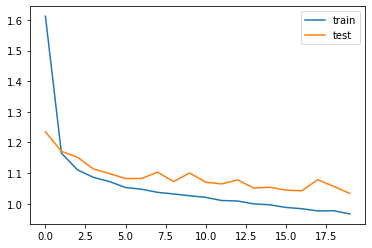

In [44]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

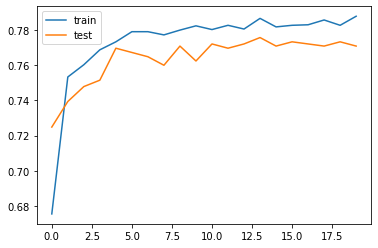

In [45]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [46]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

98925
99300
Error Percentage in predicted values is : 0.37907505686125853 %


In [47]:
f1_score(y_test, y_predicted, average = 'weighted')

0.6939777532940462

In [48]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [49]:
acc.append(max(history.history['accuracy']))

# March

In [50]:
working_df = house_data[house_data.Month == 3]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5700, 34) (5700, 21) (1426, 34) (1426, 21)


In [51]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 5700 samples, validate on 1426 samples
Epoch 1/20
5700/5700 [==============================] - 2s 392us/sample - loss: 1.5502 - accuracy: 0.6754 - val_loss: 1.2589 - val_accuracy: 0.7454
Epoch 2/20
5700/5700 [==============================] - 2s 359us/sample - loss: 1.1573 - accuracy: 0.7584 - val_loss: 1.1925 - val_accuracy: 0.7588
Epoch 3/20
5700/5700 [==============================] - 2s 433us/sample - loss: 1.1066 - accuracy: 0.7696 - val_loss: 1.1672 - val_accuracy: 0.7616
Epoch 4/20
5700/5700 [==============================] - 2s 336us/sample - loss: 1.0780 - accuracy: 0.7747 - val_loss: 1.1529 - val_accuracy: 0.7630
Epoch 5/20
5700/5700 [==============================] - 2s 356us/sample - loss: 1.0559 - accuracy: 0.7774 - val_loss: 1.1280 - val_accuracy: 0.7700
Epoch 6/20
5700/5700 [==============================] - 2s 352us/sample - loss: 1.0384 - accuracy: 0.7796 - val_loss: 1.1149 - val_accuracy: 0.7707
Epoch 7/20
5700/5700 [==============================] - 2s 349us

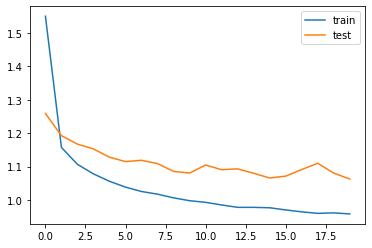

In [52]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

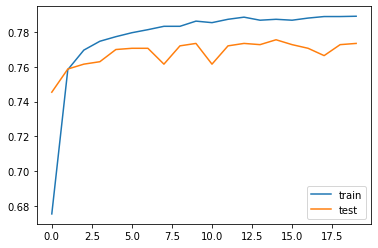

In [53]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [54]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

141930
136800
Error Percentage in predicted values is : 3.614457831325301 %


In [55]:
f1_score(y_test, y_predicted, average = 'weighted')

0.6818862404978158

In [56]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [57]:
acc.append(max(history.history['accuracy']))

# April

In [58]:
working_df = house_data[house_data.Month == 4]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5808, 34) (5808, 21) (1453, 34) (1453, 21)


In [59]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 5808 samples, validate on 1453 samples
Epoch 1/20
5808/5808 [==============================] - 3s 453us/sample - loss: 0.9744 - accuracy: 0.8280 - val_loss: 0.7187 - val_accuracy: 0.8493
Epoch 2/20
5808/5808 [==============================] - 2s 370us/sample - loss: 0.6208 - accuracy: 0.8786 - val_loss: 0.6781 - val_accuracy: 0.8596
Epoch 3/20
5808/5808 [==============================] - 2s 373us/sample - loss: 0.5921 - accuracy: 0.8860 - val_loss: 0.6498 - val_accuracy: 0.8651
Epoch 4/20
5808/5808 [==============================] - 2s 371us/sample - loss: 0.5750 - accuracy: 0.8888 - val_loss: 0.6514 - val_accuracy: 0.8679
Epoch 5/20
5808/5808 [==============================] - 3s 450us/sample - loss: 0.5631 - accuracy: 0.8903 - val_loss: 0.6604 - val_accuracy: 0.8630
Epoch 6/20
5808/5808 [==============================] - 2s 396us/sample - loss: 0.5552 - accuracy: 0.8936 - val_loss: 0.6209 - val_accuracy: 0.8685
Epoch 7/20
5808/5808 [==============================] - 2s 402us

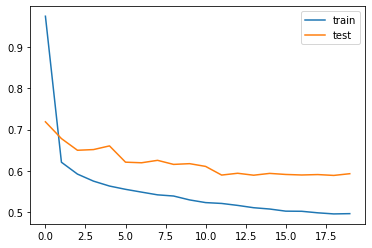

In [60]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

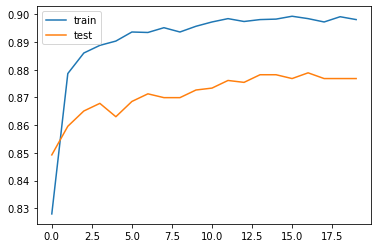

In [61]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [62]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

64560
58200
Error Percentage in predicted values is : 9.851301115241636 %


In [63]:
f1_score(y_test, y_predicted, average = 'weighted')

0.8282024234705411

In [64]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [65]:
acc.append(max(history.history['accuracy']))

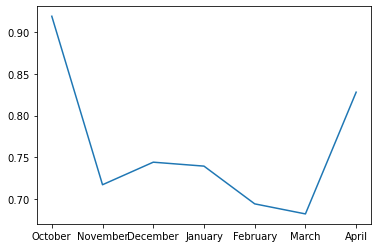

In [66]:
sns.lineplot(x = months, y = f1, sort = False)

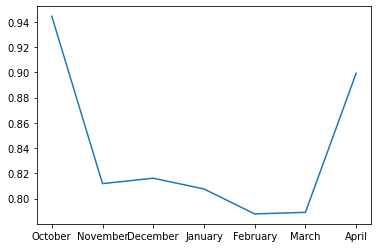

In [67]:
sns.lineplot(x = months, y = acc, sort = False)

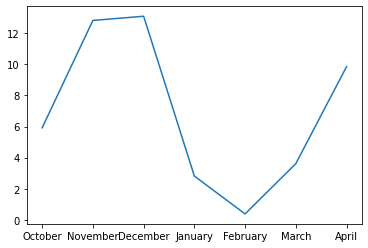

In [68]:
sns.lineplot(x = months, y = err, sort = False)